#Autoencoders

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called *latent representations* or *codings*, without any supervision. These encodings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction.





In [1]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten, Dropout
from tensorflow.keras.layers import Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [2]:
import numpy as np
import matplotlib.pyplot as plt

Load mnist data to get the training, validation and test data sets.

In [3]:
(x_train_full, y_train_full), (x_test, y_test) = mnist.load_data()
x_train_full = x_train_full.astype(np.float32) / 255
x_test = x_test.astype(np.float32) / 255
x_train, x_valid = x_train_full[:-5000], x_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [4]:
print(x_train.shape, x_valid.shape, x_test.shape)

(55000, 28, 28) (5000, 28, 28) (10000, 28, 28)


In [5]:
image_size = x_train.shape[1]

In [6]:
# network parameters
input_shape = (image_size, image_size)
batch_size = 32
latent_dim = 16
layer_units = [32, 64]

In [7]:
# build the autoencoder model
# first build the encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
# stack of Dense(32)-Dense(64)
x = Dropout(0.5)(x)
for units in layer_units:
    x = Dense(units=units,activation='relu')(x)

In [8]:
# shape info needed to build decoder model

shape = K.int_shape(x)

In [9]:
shape

(None, 28, 64)

In [10]:
# generate latent vector
x = Flatten()(x)
latent = Dense(latent_dim, name='latent_vector')(x)

In [11]:
# instantiate encoder model
encoder = Model(inputs,
                latent,
                name='encoder')
encoder.summary()

Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28)]          0         
_________________________________________________________________
dropout (Dropout)            (None, 28, 28)            0         
_________________________________________________________________
dense (Dense)                (None, 28, 32)            928       
_________________________________________________________________
dense_1 (Dense)              (None, 28, 64)            2112      
_________________________________________________________________
flatten (Flatten)            (None, 1792)              0         
_________________________________________________________________
latent_vector (Dense)        (None, 16)                28688     
Total params: 31,728
Trainable params: 31,728
Non-trainable params: 0
_______________________________________________________

In [12]:
# build the decoder model
latent_inputs = Input(shape=(latent_dim,), name='decoder_input')
# use the shape info that was earlier saved
x = Dense(shape[1] * shape[2])(latent_inputs)
# from vector to suitable shape
x = Reshape((shape[1], shape[2]))(x)

In [13]:
# stack of Dense(64)-Dense(32)
for units in layer_units[::-1]:
    x = Dense(units=units, activation='relu')(x)

In [14]:
# reconstruct the input
outputs = Dense(image_size, activation='sigmoid',
                          name='decoder_output')(x)

In [15]:
# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 16)]              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1792)              30464     
_________________________________________________________________
reshape (Reshape)            (None, 28, 64)            0         
_________________________________________________________________
dense_3 (Dense)              (None, 28, 64)            4160      
_________________________________________________________________
dense_4 (Dense)              (None, 28, 32)            2080      
_________________________________________________________________
decoder_output (Dense)       (None, 28, 28)            924       
Total params: 37,628
Trainable params: 37,628
Non-trainable params: 0
_______________________________________________________

In [16]:
# autoencoder = encoder + decoder
# instantiate autoencoder model
autoencoder = Model(inputs,
                    decoder(encoder(inputs)),
                    name='autoencoder')
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   [(None, 28, 28)]          0         
_________________________________________________________________
encoder (Functional)         (None, 16)                31728     
_________________________________________________________________
decoder (Functional)         (None, 28, 28)            37628     
Total params: 69,356
Trainable params: 69,356
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Mean Square Error (MSE) loss function, Adam optimizer
autoencoder.compile(loss='mse', optimizer='adam')

In [18]:
# train the autoencoder
history = autoencoder.fit(x_train,
                x_train,
                validation_data=(x_valid, x_valid),
                epochs=10,
                batch_size=batch_size)

Epoch 1/10
1719/1719 [==============================] - 7s 4ms/step - loss: 0.0348 - val_loss: 0.0228
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0199 - val_loss: 0.0206
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0184 - val_loss: 0.0194
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0175 - val_loss: 0.0220
Epoch 5/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.0170 - val_loss: 0.0236
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0167 - val_loss: 0.0246
Epoch 7/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0164 - val_loss: 0.0262
Epoch 8/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0161 - val_loss: 0.0262
Epoch 9/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.0159 - val_loss: 0.0285
Epoch 10/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.015

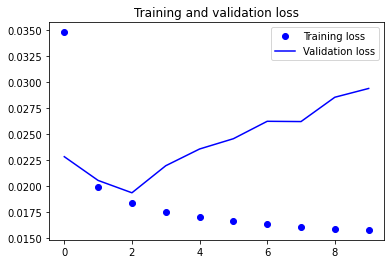

In [19]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [20]:
# predict the autoencoder output from test data
x_decoded = autoencoder.predict(x_test)

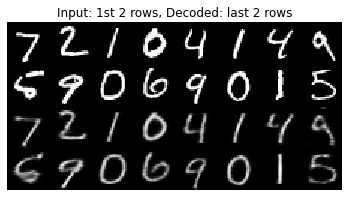

In [21]:
# display the 1st 16 test input and decoded images
imgs = np.concatenate([x_test[:16], x_decoded[:16]])
imgs = imgs.reshape((4, 8, image_size, image_size))
imgs = np.vstack([np.hstack(i) for i in imgs])
plt.figure()
plt.axis('off')
plt.title('Input: 1st 2 rows, Decoded: last 2 rows')
plt.imshow(imgs, interpolation='none', cmap='gray')
plt.savefig('input_and_decoded.png')
plt.show()

#Dimensionality reduction using autoencoder for image classification

We can use the encoder to compress each image to 16 floating point numbers. Each image is stored using only 64 bytes.

We want to know how good these representations are for classification purposes. 

We decode these representations and feed the results to a convnet net. We compare the accuracy results with the results from the original images.

In [22]:
x_train_decoded = autoencoder.predict(x_train)
x_valid_decoded = autoencoder.predict(x_valid)
x_test_decoded = autoencoder.predict(x_test)
x_train_decoded = np.reshape(x_train_decoded, [-1, image_size, image_size, 1])
x_valid_decoded = np.reshape(x_valid_decoded, [-1, image_size, image_size, 1])
x_test_decoded = np.reshape(x_test_decoded, [-1, image_size, image_size, 1])

In [23]:
print(x_train_decoded.shape, x_valid_decoded.shape, x_test_decoded.shape)

(55000, 28, 28, 1) (5000, 28, 28, 1) (10000, 28, 28, 1)


In [24]:
print(y_train.shape, y_valid.shape, y_test.shape)

(55000,) (5000,) (10000,)


We define a Convnet to classify these images.

In [25]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), strides=2, padding='same', activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3, 3), strides=2, padding='same', activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 4, 4, 64)          18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 2, 2, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                4112      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1

In [26]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train_decoded, y_train, validation_data=(x_valid_decoded, y_valid), epochs=20, batch_size=32)

Epoch 1/20
1719/1719 [==============================] - 17s 3ms/step - loss: 0.7673 - accuracy: 0.7498 - val_loss: 0.1743 - val_accuracy: 0.9496
Epoch 2/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2099 - accuracy: 0.9359 - val_loss: 0.1618 - val_accuracy: 0.9524
Epoch 3/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1685 - accuracy: 0.9466 - val_loss: 0.1370 - val_accuracy: 0.9592
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.1461 - accuracy: 0.9549 - val_loss: 0.1161 - val_accuracy: 0.9656
Epoch 5/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1335 - accuracy: 0.9576 - val_loss: 0.1176 - val_accuracy: 0.9660
Epoch 6/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1196 - accuracy: 0.9622 - val_loss: 0.1288 - val_accuracy: 0.9622
Epoch 7/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.1162 - accuracy: 0.9640 - val_loss: 0.1339 - val_accuracy

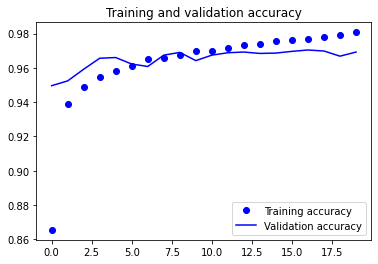

In [27]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

epochs = range(len(accuracy))

plt.figure()

plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.show()

In [28]:
test_loss, test_acc = model.evaluate(x_test_decoded, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.1251 - accuracy: 0.9646


Using the decoded images, we achieve 96.46% of accuracy.

Now we repeat the process for the original images.

In [29]:
x_train = np.reshape(x_train, [-1, image_size, image_size, 1])
x_valid = np.reshape(x_valid, [-1, image_size, image_size, 1])
x_test = np.reshape(x_test, [-1, image_size, image_size, 1])

In [30]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), epochs=20, batch_size=32)

Epoch 1/20
1719/1719 [==============================] - 5s 3ms/step - loss: 0.1481 - accuracy: 0.9641 - val_loss: 0.0758 - val_accuracy: 0.9798
Epoch 2/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0587 - accuracy: 0.9822 - val_loss: 0.0644 - val_accuracy: 0.9846
Epoch 3/20
1719/1719 [==============================] - 4s 3ms/step - loss: 0.0413 - accuracy: 0.9876 - val_loss: 0.0543 - val_accuracy: 0.9840
Epoch 4/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0330 - accuracy: 0.9900 - val_loss: 0.0524 - val_accuracy: 0.9854
Epoch 5/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0250 - accuracy: 0.9921 - val_loss: 0.0670 - val_accuracy: 0.9852
Epoch 6/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0208 - accuracy: 0.9932 - val_loss: 0.0572 - val_accuracy: 0.9864
Epoch 7/20
1719/1719 [==============================] - 4s 2ms/step - loss: 0.0179 - accuracy: 0.9946 - val_loss: 0.0542 - val_accuracy:

In [31]:
test_loss, test_acc = model.evaluate(x_test, y_test)

313/313 [==============================] - 1s 2ms/step - loss: 0.0766 - accuracy: 0.9845


The original image achieves 98.45% of accuracy.

In this example, we use autoencoder to compress MNIST images. Each images is compressed from 28x28 = 784 bytes to 16*4 = 64 bytes. That is a compression ratio of 12.25. 

By using the compressed images we can still achieve 96.46% of accuracy using a convnet, while using the original images achieves 98.45% of accuracy with the same convnet configurations.